# CS236 Project - Phase 2

Beniel Immanuel - 862540105

Siddharta Dutta -  862292896


## 0. Library Imports + Spark

In [ ]:
# import libraries
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from pyspark.sql.types import *

import matplotlib.pyplot as plt
import seaborn as sns

import pathlib
from pathlib import Path
import os
import subprocess



# set up plot
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# ----- Ben Setup -----
#java 17 installation
java_17_path = r"C:\Users\benie\Downloads\jdk-17"
os.environ['JAVA_HOME'] = java_17_path
print(f"JAVA_HOME: {os.environ.get('JAVA_HOME')}")

# Add Java to PATH
java_17_bin = r"C:\Users\benie\Downloads\jdk-17\bin"
current_path = os.environ.get('PATH', '')
os.environ['PATH'] = java_17_bin + ';' + current_path

print(f"PATH: {java_17_bin}")

JAVA_HOME: C:\Users\benie\Downloads\jdk-17
PATH: C:\Users\benie\Downloads\jdk-17\bin


In [3]:
# ----- Sid Setup ----- 

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] = f"{os.environ['JAVA_HOME']}/bin:" + os.environ["PATH"]

print(os.environ["JAVA_HOME"])
print(os.environ["PATH"])

/usr/lib/jvm/java-11-openjdk-amd64
/usr/lib/jvm/java-11-openjdk-amd64/bin:C:\Users\benie\Downloads\jdk-17\bin;/home/siddh/Projects/dbms/venv/bin:/home/siddh/.local/bin:/home/siddh/Downloads/usr/bin:/home/siddh/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin:/home/siddh/tools/vcpkg


In [4]:
JAR = "/tmp/postgresql-42.7.3.jar"

# ensure jar exists
if not pathlib.Path(JAR).exists():
    subprocess.run(
        "curl -L -o /tmp/postgresql-42.7.3.jar "
        "https://repo1.maven.org/maven2/org/postgresql/postgresql/42.7.3/postgresql-42.7.3.jar",
        shell=True, check=True
    )

# Make PySpark start JVM with jar on classpath
os.environ["PYSPARK_SUBMIT_ARGS"] = f"--driver-class-path {JAR} --jars {JAR} pyspark-shell"
print("PYSPARK_SUBMIT_ARGS =", os.environ["PYSPARK_SUBMIT_ARGS"])
print("Jar exists:", pathlib.Path(JAR).exists(), "size:", pathlib.Path(JAR).stat().st_size, "bytes")


PYSPARK_SUBMIT_ARGS = --driver-class-path /tmp/postgresql-42.7.3.jar --jars /tmp/postgresql-42.7.3.jar pyspark-shell
Jar exists: True size: 1089312 bytes


In [5]:
spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("CS236_Phase2_Postgres")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
    .config("spark.jars", "/tmp/postgresql-42.7.3.jar")
    .config("spark.driver.extraClassPath", "/tmp/postgresql-42.7.3.jar")
    .config("spark.executor.extraClassPath", "/tmp/postgresql-42.7.3.jar")
    .getOrCreate()
)

# For debug: class to driver JVM
spark._jvm.java.lang.Class.forName("org.postgresql.Driver")
print("JDBC class visible; master =", spark.sparkContext.master)

# For debug: show jars on classpath
# jlist = spark.sparkContext._jsc.sc().listJars()
# print("Num jars:", jlist.size())
# for i in range(jlist.size()):
#     print(jlist.apply(i))


25/11/04 20:47:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


JDBC class visible; master = local[*]


## 1. Phase 1 Reclean

To make sure we don't remove cancellations like we did in Phase 1. Recleaning data to match TA's notes.

In [ ]:
# Get paths of raw files
RAW_HOTEL = Path("/home/siddh/Projects/dbms/hotel-booking.csv")
RAW_CUSTOMER = Path("/home/siddh/Projects/dbms/customer-reservations.csv")

OUT_DIR = Path("output")
OUT_DIR.mkdir(exist_ok=True)

print("Hotel raw:", RAW_HOTEL.exists(), RAW_HOTEL)
print("Customer raw:", RAW_CUSTOMER.exists(), RAW_CUSTOMER)


Hotel raw: True /home/siddh/Projects/dbms/hotel-booking.csv
Customer raw: True /home/siddh/Projects/dbms/customer-reservations.csv


In [ ]:
# Read csv
def read_csv(path: Path):
    return (spark.read
            .option("header", True)
            .option("inferSchema", True)
            .csv(str(path)))

# Make cols lower
def lower_cols(df):
    for c in df.columns:
        df = df.withColumnRenamed(c, c.lower())
    return df

hotel_raw = lower_cols(read_csv(RAW_HOTEL))
cust_raw  = lower_cols(read_csv(RAW_CUSTOMER))

# Print schemas
print("Hotel schema:"); hotel_raw.printSchema()
print("Customer schema:"); cust_raw.printSchema()


Hotel schema:
root
 |-- hotel: string (nullable = true)
 |-- booking_status: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- arrival_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- market_segment_type: string (nullable = true)
 |-- country: string (nullable = true)
 |-- avg_price_per_room: double (nullable = true)
 |-- email: string (nullable = true)

Customer schema:
root
 |-- booking_id: string (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- arrival_month: integer (nullable = true)
 |-- arrival_date: integer (nullable = true)
 |-- market_

In [ ]:
# For all columns, clean and reformat all string type
def lowercase_string_columns(df):
    for c, t in df.dtypes:
        if t == "string":
            df = df.withColumn(c, F.lower(F.trim(F.col(c))))
    return df

hotel = lowercase_string_columns(hotel_raw)
customer = lowercase_string_columns(cust_raw)


In [ ]:
# Translate months to numeric 1-12
MONTH_MAP = {
    "january":1,"february":2,"march":3,"april":4,"may":5,"june":6,
    "july":7,"august":8,"september":9,"october":10,"november":11,"december":12
}

def find_month_col(df):
    candidates = ["arrival_date_month","arrival_month","month","booking_month"]
    lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand in lower:
            return lower[cand]
    return None

def ensure_month_numeric(df):
    mcol = find_month_col(df)
    if not mcol:
        return df
    mapping_expr = F.create_map(*[x for k,v in MONTH_MAP.items() for x in (F.lit(k), F.lit(v))])
    return df.withColumn("arrival_month_num",
                F.when(F.col(mcol).cast("int").isNotNull(), F.col(mcol).cast("int"))
                 .otherwise(mapping_expr[F.col(mcol)]))

hotel = ensure_month_numeric(hotel)
customer = ensure_month_numeric(customer)


In [ ]:
# Find matching col from variants
def choose_col(df, options):
    lower = {c.lower(): c for c in df.columns}
    for opt in options:
        if opt in lower:
            return lower[opt]
    return None

# Standardize col names + types
def with_standard_types(df):
    ycol = choose_col(df, ["arrival_date_year","arrival_year","year"])
    if ycol:
        df = df.withColumn("arrival_year", F.col(ycol).cast("int"))
    mcol = choose_col(df, ["market_segment","market_segment_type","segment"])
    if mcol:
        df = df.withColumn("market_segment", F.col(mcol))
    wkn = choose_col(df, ["stays_in_week_nights","week_nights","nights_week"])
    wke = choose_col(df, ["stays_in_weekend_nights","weekend_nights","nights_weekend"])
    if wkn: df = df.withColumn("stays_in_week_nights", F.col(wkn).cast("double"))
    if wke: df = df.withColumn("stays_in_weekend_nights", F.col(wke).cast("double"))
    adr = choose_col(df, ["adr","avg_price_per_room","price","average_daily_rate"])
    if adr: df = df.withColumn("adr", F.col(adr).cast("double"))
    bstat = choose_col(df, ["booking_status","status","is_canceled","is_cancelled"])
    if bstat: df = df.withColumn("booking_status_raw", F.col(bstat))
    return df

hotel = with_standard_types(hotel)
customer = with_standard_types(customer)


In [ ]:
# Normalize cancelled + not cancelled
def normalize_booking_status(df):
    col = "booking_status_raw" if "booking_status_raw" in df.columns else           ("booking_status" if "booking_status" in df.columns else None)
    if not col:
        return df.withColumn("booking_status","not cancelled").withColumn("is_canceled", F.lit(0).cast("int"))
    s = F.lower(F.trim(F.col(col).cast("string")))
    df = df.withColumn(
        "booking_status",
        F.when(s.isin("1","true","t","y","yes","canceled","cancelled","cancel","cancellation"), "cancelled")
         .when(s.isin("0","false","f","n","no","not cancelled","not canceled","active","checked-out","confirmed","arrived"), "not cancelled")
         .otherwise(F.when(F.col(col).cast("int")==1, "cancelled").otherwise("not cancelled"))
    )
    df = df.withColumn("is_canceled", F.when(F.col("booking_status")=="cancelled", F.lit(1)).otherwise(F.lit(0)).cast("int"))
    return df

hotel = normalize_booking_status(hotel)
customer = normalize_booking_status(customer)


In [ ]:
all_cols = sorted(set(hotel.columns) | set(customer.columns))

def align_safe(df, all_cols):
    # add missing cols as string null
    for c in all_cols:
        if c not in df.columns:
            df = df.withColumn(c, F.lit(None).cast(StringType()))
    # ensure string null
    for name, dtype in df.dtypes:
        if dtype.lower() in ("null", "void"):
            df = df.withColumn(name, F.col(name).cast(StringType()))
    return df.select(*all_cols)

hotel_aligned    = align_safe(hotel, all_cols)
customer_aligned = align_safe(customer, all_cols)
unified_df       = hotel_aligned.unionByName(customer_aligned)

In [ ]:
# Write Spark DF to csv
def write_single_csv(df, final_path: Path):
    tmp = Path(str(final_path) + "_tmp")
    (df.coalesce(1).write.mode("overwrite").option("header", True).csv(str(tmp)))
    part = list(tmp.glob("part-*.csv"))[0]
    part.replace(final_path)
    for p in tmp.glob("*"):
        try: p.unlink()
        except: pass
    try: tmp.rmdir()
    except: pass

write_single_csv(hotel_aligned, OUT_DIR/"hotel_cleaned_single.csv")
write_single_csv(customer_aligned, OUT_DIR/"customer_cleaned_single.csv")
write_single_csv(unified_df, OUT_DIR/"merged_dataset_single.csv")

print("Wrote:")
print((OUT_DIR/'hotel_cleaned_single.csv').resolve())
print((OUT_DIR/'customer_cleaned_single.csv').resolve())
print((OUT_DIR/'merged_dataset_single.csv').resolve())


Wrote:
/home/siddh/Projects/dbms/output/hotel_cleaned_single.csv
/home/siddh/Projects/dbms/output/customer_cleaned_single.csv
/home/siddh/Projects/dbms/output/merged_dataset_single.csv


## 2. Load Phase 1 CSVs

In [ ]:
# Find csvs
CSV_HOTEL = "output/hotel_cleaned_single.csv"
CSV_CUSTOMER = "output/customer_cleaned_single.csv"
CSV_UNIFIED = "output/merged_dataset_single.csv"

print("Hotel CSV    :", CSV_HOTEL)
print("Customer CSV :", CSV_CUSTOMER)
print("Unified CSV  :", CSV_UNIFIED)

# Load csvs
def load_csv(path):
    return (spark.read.option("header", True).option("inferSchema", True).csv(str(path)))

hotel_df = load_csv(CSV_HOTEL)
customer_df = load_csv(CSV_CUSTOMER)
unified_df = load_csv(CSV_UNIFIED)

print("Hotel rows   :", hotel_df.count())
print("Customer rows:", customer_df.count())
print("Unified rows :", unified_df.count())

hotel_df.printSchema()
customer_df.printSchema()
unified_df.printSchema()

Hotel CSV    : output/hotel_cleaned_single.csv
Customer CSV : output/customer_cleaned_single.csv
Unified CSV  : output/merged_dataset_single.csv
Hotel rows   : 78703
Customer rows: 36275
Unified rows : 114978
root
 |-- adr: double (nullable = true)
 |-- arrival_date: string (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_month: string (nullable = true)
 |-- arrival_month_num: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- avg_price_per_room: double (nullable = true)
 |-- booking_id: string (nullable = true)
 |-- booking_status: string (nullable = true)
 |-- booking_status_raw: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- email: string (nullable = true)
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- market_segmen

## 3. Column Inference & Normalization

In [ ]:
REQUIRED = [
    "is_canceled", "arrival_year", "arrival_month_num", "adr",
    "stays_in_week_nights", "stays_in_weekend_nights", "market_segment"
]

def _require(df: DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns for Phase 2: {missing}")

# Fixes col mapping + keep original shape
def infer_columns(df: DataFrame):
    _require(df, REQUIRED)
    return {
        "cancel": "is_canceled",
        "price": "adr",
        "nights_week": "stays_in_week_nights",
        "nights_weekend": "stays_in_weekend_nights",
        "market": "market_segment",
        "year": "arrival_year",
        "month_num": "arrival_month_num",
        "month_name": "arrival_month" if "arrival_month" in df.columns else None,
    }

# Build engineered fields
# canceled, price, nights, market seg, yr month, revenue
def add_engineered_columns(df: DataFrame, meta: dict):
    _require(df, REQUIRED)

    out = (
        df
        .withColumn("_is_canceled", F.col(meta["cancel"]).cast("int"))
        .withColumn("_price", F.col(meta["price"]).cast("double"))
        .withColumn(
            "_nights",
            F.col(meta["nights_week"]).cast("double") + F.col(meta["nights_weekend"]).cast("double")
        )
        .withColumn("_market_segment", F.col(meta["market"]))
        .withColumn("_year_month", F.expr(f"make_date({meta['year']}, {meta['month_num']}, 1)"))
    )

    # Revenue only if not canceled
    out = out.withColumn(
        "_revenue",
        F.when(F.col("_is_canceled") == 0, F.col("_price") * F.col("_nights")).otherwise(F.lit(0.0))
    )

    return out

# For Debug: print cancel counts
if infer_columns(unified_df)["cancel"]:
    (unified_df
        .select(F.lower(F.trim(F.col(infer_columns(unified_df)["cancel"]).cast("string"))).alias("cancel_str"))
        .groupBy("cancel_str").count().orderBy(F.desc("count")).show(30, truncate=False))


+----------+-----+
|cancel_str|count|
+----------+-----+
|0         |74614|
|1         |40364|
+----------+-----+



In [ ]:
# Build dataframe
meta = infer_columns(unified_df)
prepared_df = add_engineered_columns(unified_df, meta).cache()

prepared_df.select(
    "_year_month", "_is_canceled", "_price", "_nights", "_market_segment", "_revenue"
).show(5, truncate=False)


+-----------+------------+------+-------+---------------+--------+
|_year_month|_is_canceled|_price|_nights|_market_segment|_revenue|
+-----------+------------+------+-------+---------------+--------+
|2015-07    |0           |0.0   |0.0    |direct         |0.0     |
|2015-07    |0           |0.0   |0.0    |direct         |0.0     |
|2015-07    |0           |75.0  |1.0    |direct         |75.0    |
|2015-07    |0           |75.0  |1.0    |corporate      |75.0    |
|2015-07    |0           |98.0  |2.0    |online ta      |196.0   |
+-----------+------------+------+-------+---------------+--------+
only showing top 5 rows



## 4. Spark Analysis

In [25]:
# (1) Cancellation rate per month
cancel_by_month = (prepared_df
    .groupBy("_year_month")
    .agg(
        F.sum("_is_canceled").alias("canceled"),
        F.count(F.lit(1)).alias("total")
    )
    .withColumn("cancellation_rate", (F.col("canceled")/F.col("total")).cast("double"))
    .orderBy("_year_month")
)

# (2) Average price & average nights per month
avg_by_month = (prepared_df
    .groupBy("_year_month")
    .agg(F.avg("_price").alias("avg_price"),
         F.avg("_nights").alias("avg_nights"))
    .orderBy("_year_month")
)

# (3) Monthly bookings by market segment
bookings_by_segment = (prepared_df
    .groupBy("_year_month","_market_segment")
    .agg(F.count(F.lit(1)).alias("bookings"))
    .orderBy("_year_month","_market_segment")
)

# (4) Most popular month by revenue (seasonality)
revenue_by_month = (prepared_df
    .groupBy("_year_month")
    .agg(F.sum("_revenue").alias("revenue"))
    .orderBy(F.col("revenue").desc())
)

most_popular_month = revenue_by_month.limit(1)

print("== Cancellation rate per month ==")
cancel_by_month.show(12, truncate=False)
print("\n== Average price & nights per month ==")
avg_by_month.show(12, truncate=False)
print("\n== Monthly bookings by market segment ==")
bookings_by_segment.show(24, truncate=False)
print("\n== Revenue by month (Top 10) ==")
revenue_by_month.show(10, truncate=False)
print("\n== Most popular month by revenue ==")
most_popular_month.show(truncate=False)


== Cancellation rate per month ==
+-----------+--------+-----+-------------------+
|_year_month|canceled|total|cancellation_rate  |
+-----------+--------+-----+-------------------+
|2015-07    |1259    |2776 |0.4535302593659942 |
|2015-08    |1598    |3889 |0.4109025456415531 |
|2015-09    |2094    |5114 |0.409464215877982  |
|2015-10    |1732    |4957 |0.34940488198507164|
|2015-11    |486     |2340 |0.2076923076923077 |
|2015-12    |973     |2920 |0.33321917808219176|
|2016-01    |557     |2248 |0.24777580071174377|
|2016-02    |1337    |3891 |0.34361346697507067|
|2016-03    |1477    |4824 |0.3061774461028192 |
|2016-04    |2061    |5428 |0.37969786293294033|
|2016-05    |1915    |5478 |0.34958013873676524|
|2016-06    |2096    |5292 |0.3960695389266818 |
+-----------+--------+-----+-------------------+
only showing top 12 rows


== Average price & nights per month ==
+-----------+------------------+------------------+
|_year_month|avg_price         |avg_nights        |
+-----------

## Plots From Analysis

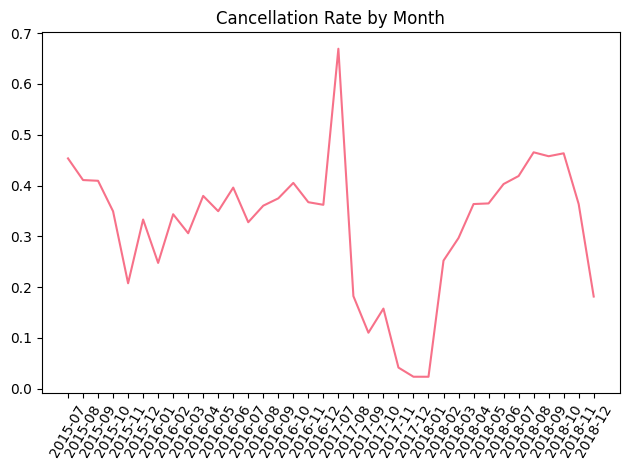

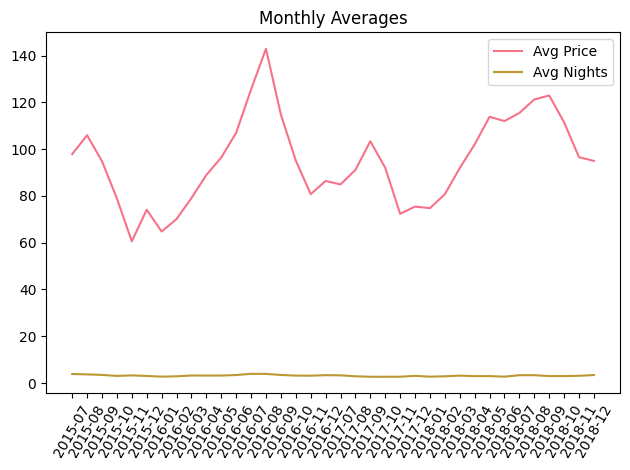

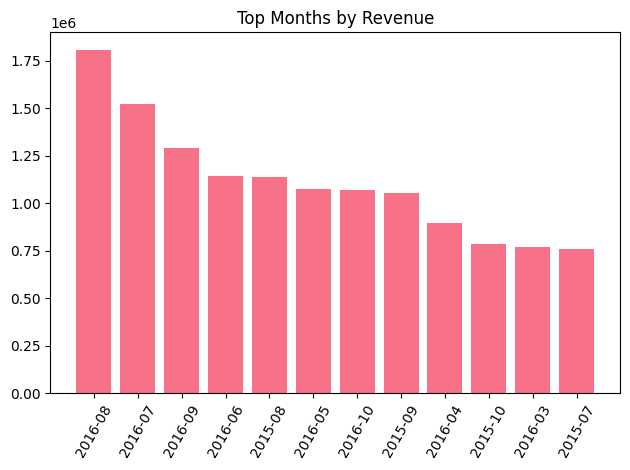

In [ ]:

pdf_cancel  = cancel_by_month.toPandas()
pdf_avg     = avg_by_month.toPandas()
pdf_revenue = revenue_by_month.toPandas()

# Cancellation Rate by Month
plt.figure()
plt.plot(pdf_cancel["_year_month"], pdf_cancel["cancellation_rate"])
plt.title("Cancellation Rate by Month")
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

# Monthly Averages
plt.figure()
plt.plot(pdf_avg["_year_month"], pdf_avg["avg_price"], label="Avg Price")
plt.plot(pdf_avg["_year_month"], pdf_avg["avg_nights"], label="Avg Nights")
plt.legend()
plt.title("Monthly Averages")
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

# Top months by revenue
plt.figure()
plt.bar(pdf_revenue["_year_month"].head(12), pdf_revenue["revenue"].head(12))
plt.title("Top Months by Revenue")
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()


## 5. PostgreSQL in Docker

In [ ]:
# Start PostgreSql image:
"""
docker run -d \
  --name cs236_pg \
  -e POSTGRES_USER=cs236user \
  -e POSTGRES_PASSWORD=cs236pass \
  -e POSTGRES_DB=cs236db \
  -p 5432:5432 \
  postgres:16
"""

# Check if running
"""
docker logs cs236_pg
"""

# Reminder: rerun last with sudo
"""
sudo !!
"""


'\nsudo !!\n'

## 6. Write DataFrames to PostgreSQL

In [ ]:
# build jdbc connector
jdbc_url = "jdbc:postgresql://localhost:5432/cs236db"
jdbc_props = {
    "user": "cs236user",
    "password": "cs236pass",
    "driver": "org.postgresql.Driver"
}

# write Spark DF to Postgres db 
def maybe_write(df, table):
    if df is None:
        print(f"[SKIP] {table} is None / not found.")
        return
    try:
        (df.write
            .format("jdbc")
            .options(**jdbc_props)
            .option("url", jdbc_url)
            .option("dbtable", table)
            .mode("overwrite")
            .save())
        print(f"[OK] Wrote to table: {table}")
    except Exception as e:
        print(f"[ERROR] Writing table {table} failed:", e)

maybe_write(hotel_df,   "hotel")   
maybe_write(customer_df,"customer")   
maybe_write(unified_df, "unified")


[OK] Wrote to table: hotel


[OK] Wrote to table: customer


[OK] Wrote to table: unified


## 6. Export SQL

In [ ]:

# Dump SQL from PostgreSQL:
"""
docker exec -t cs236_pg pg_dump -U cs236user cs236db > phase2_dump.sql
"""


'\ndocker exec -t cs236_pg pg_dump -U cs236user cs236db > phase2_dump.sql\n'